In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.n_jobs = 6

scanpy==1.5.1 anndata==0.7.3 umap==0.4.3 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.1 statsmodels==0.11.1


/home/sliang3/miniconda3/envs/scanpy/lib/python3.8/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


In [3]:
adata = sc.read_10x_mtx("../data/Ileum/", cache=True)
adata

... reading from cache file cache/..-data-Ileum-matrix.h5ad


AnnData object with n_obs × n_vars = 39671 × 33660
    var: 'gene_ids'

In [4]:
obs = pd.read_table("../data/Ileum/Effi_tsne_final.txt", header=[0, 1])
obs.columns = [i[0] for i in obs.columns]
obs.index = obs.NAME
adata = adata[obs.NAME, :]
adata.obs = obs
adata.obs['batch'] = adata.obs.NAME.str[0:3]
adata.obs

NAME          X          Y  \
NAME                                                               
122_AAACCTGGTTCCCGAG  122_AAACCTGGTTCCCGAG -17.523981  25.760201   
122_AAAGATGTCAGCTCTC  122_AAAGATGTCAGCTCTC  -4.299636  -1.107461   
122_AAAGCAACAAGAAGAG  122_AAAGCAACAAGAAGAG  18.438143  -1.855235   
122_AAATGCCTCACCCGAG  122_AAATGCCTCACCCGAG   8.266746   4.860057   
122_AACCATGCATCACCCT  122_AACCATGCATCACCCT   1.359606  36.710104   
...                                    ...        ...        ...   
209_TTTGTCAGTCTCTTAT  209_TTTGTCAGTCTCTTAT  11.309222  21.416638   
209_TTTGTCAGTGTGGTTT  209_TTTGTCAGTGTGGTTT  23.971407   1.429820   
209_TTTGTCATCAGTTAGC  209_TTTGTCATCAGTTAGC   8.514284   0.595697   
209_TTTGTCATCGTCCAGG  209_TTTGTCATCGTCCAGG  14.008064  20.373886   
209_TTTGTCATCGTTTGCC  209_TTTGTCATCGTTTGCC  21.302798   7.139810   

                      Primary Lineages  kmeans batch  
NAME                                                  
122_AAACCTGGTTCCCGAG  IgA plasma cells       5   122  
122_AAAGATGTCAGCTCTC             Tregs       2   122  
122_AAAGCAACAAGAAGAG        Mast cells      17   122  
122_AAATGCCTCACCCGAG               TRM       3   122  
122_AACCATGCATCACCCT  IgA plasma cells      10   122  
...                                ...     ...   ...  
209_TTTGTCAGTCTCTTAT               TRM       1   209  
209_TTTGTCAGTGTGGTTT        Group3 ILC      13   209  
209_TTTGTCATCAGTTAGC               TRM       3   209  
209_TTTGTCATCGTCCAGG               TRM       1   209  
209_TTTGTCATCGTTTGCC               TRM       1   209  

[39563 rows x 6 columns]

... storing 'Primary Lineages' as categorical
... storing 'batch' as categorical


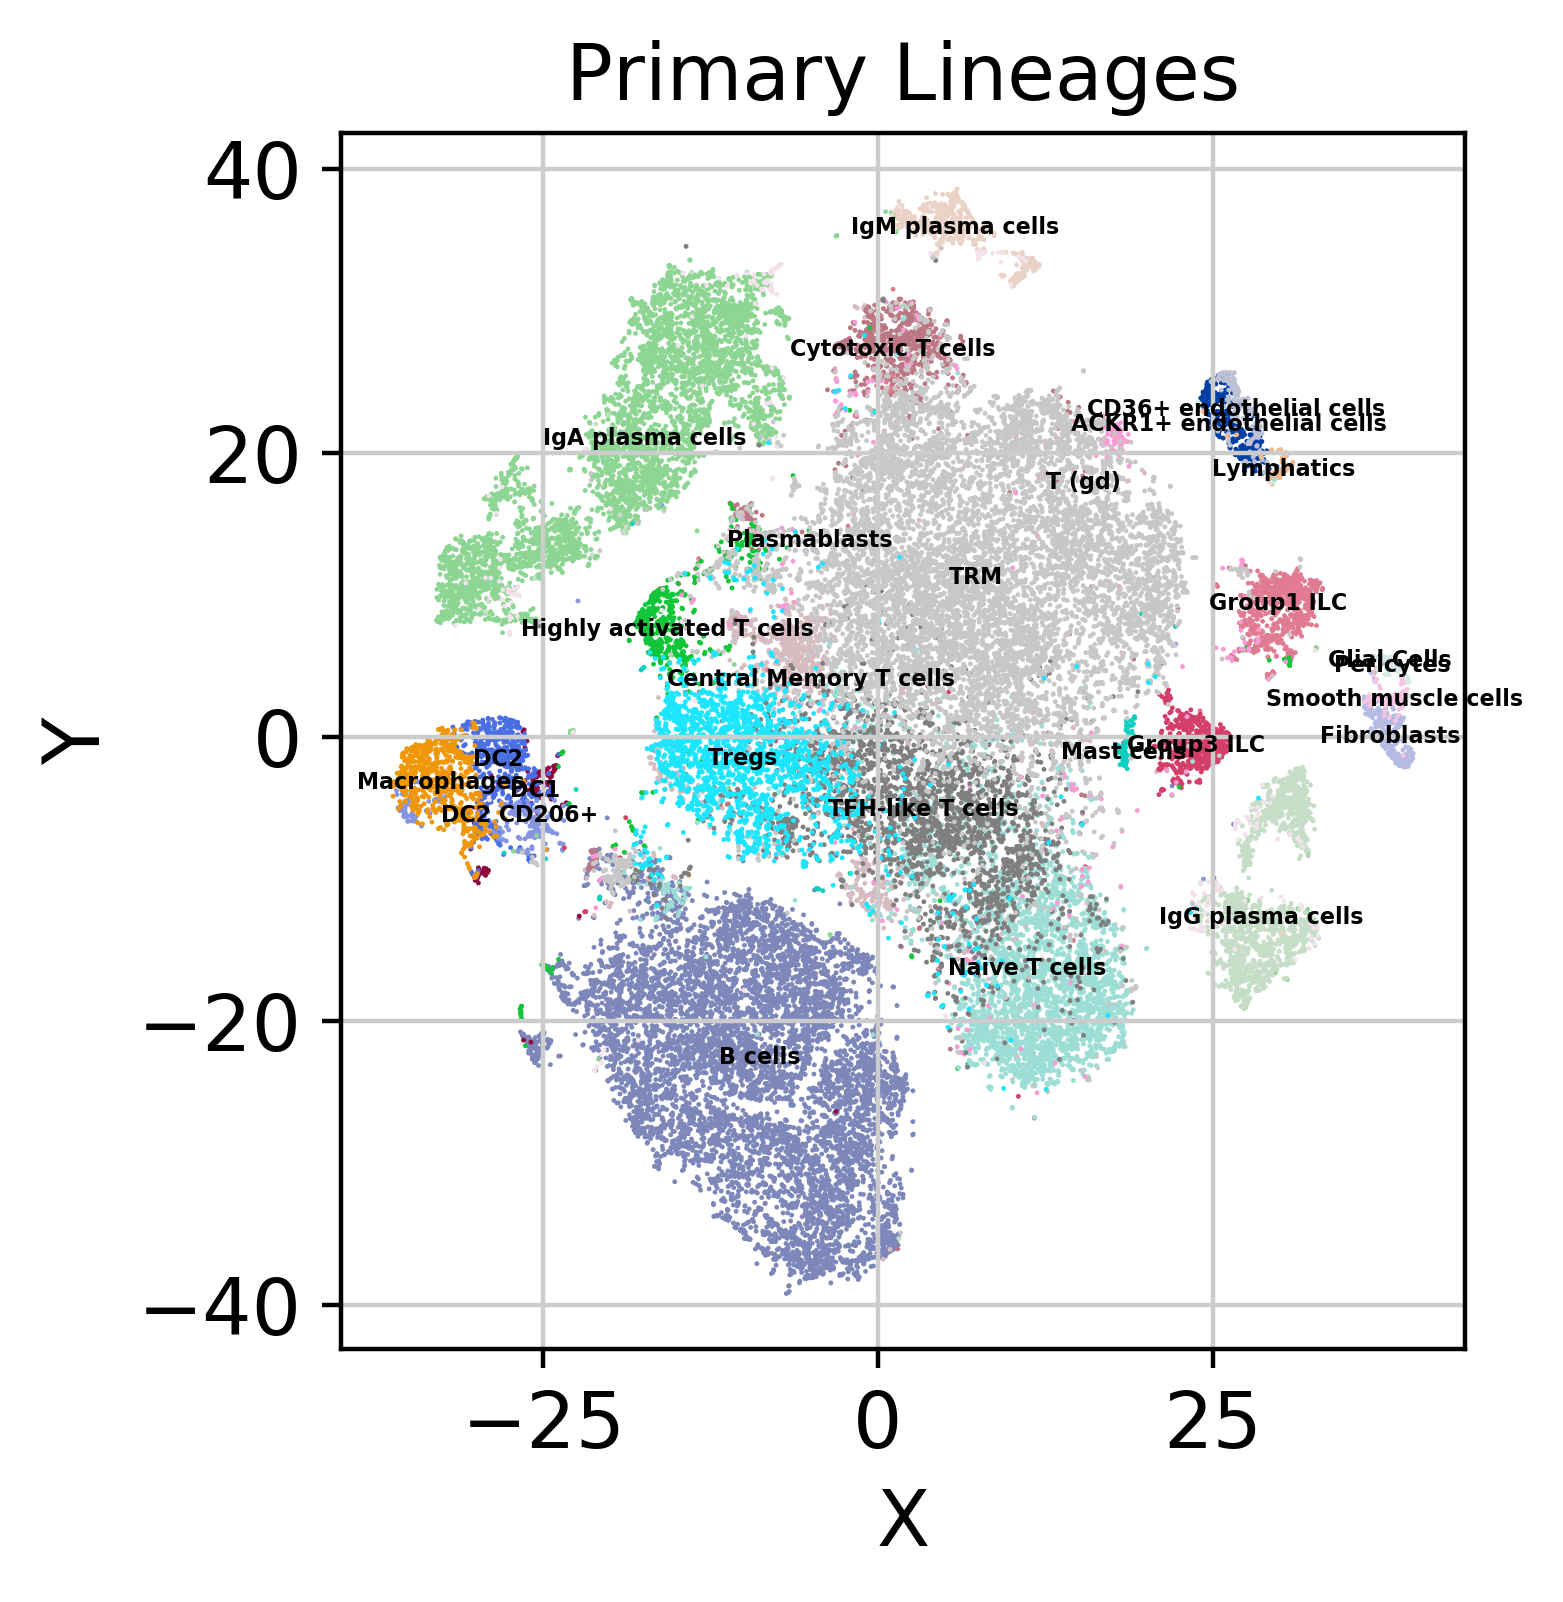

In [5]:
sc.settings.set_figure_params(dpi=200, facecolor='white')
sc.pl.scatter(adata, "X", "Y", "Primary Lineages", legend_loc="on data", legend_fontsize=4, frameon=False)

## QC

The dataset is already filtered, so no need to do additional QC.
Nevertheless, we show the figures.

normalizing counts per cell
    finished (0:00:00)


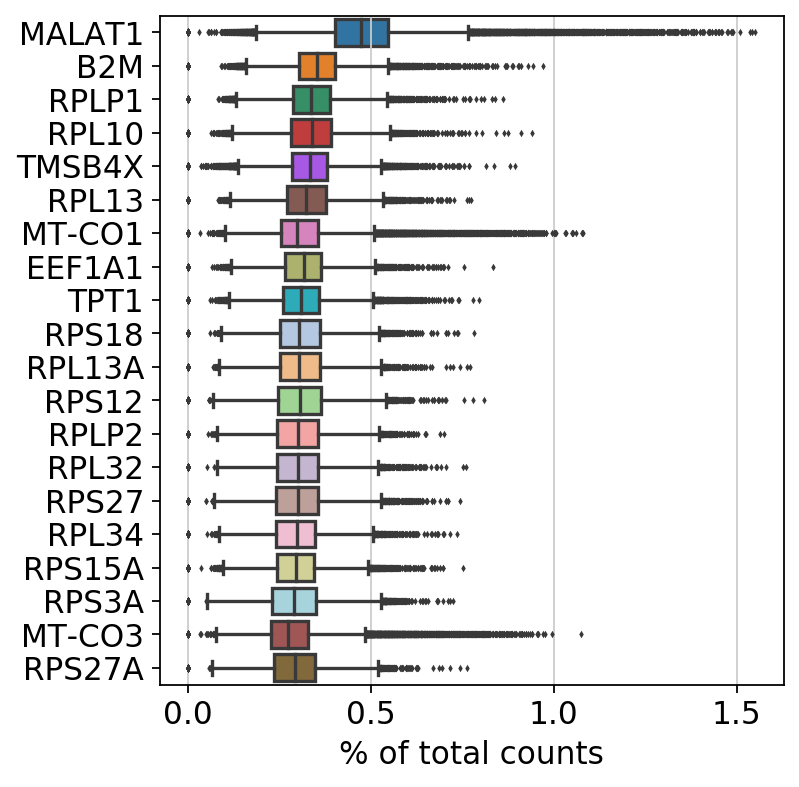

In [6]:
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.pl.highest_expr_genes(adata, n_top=20)

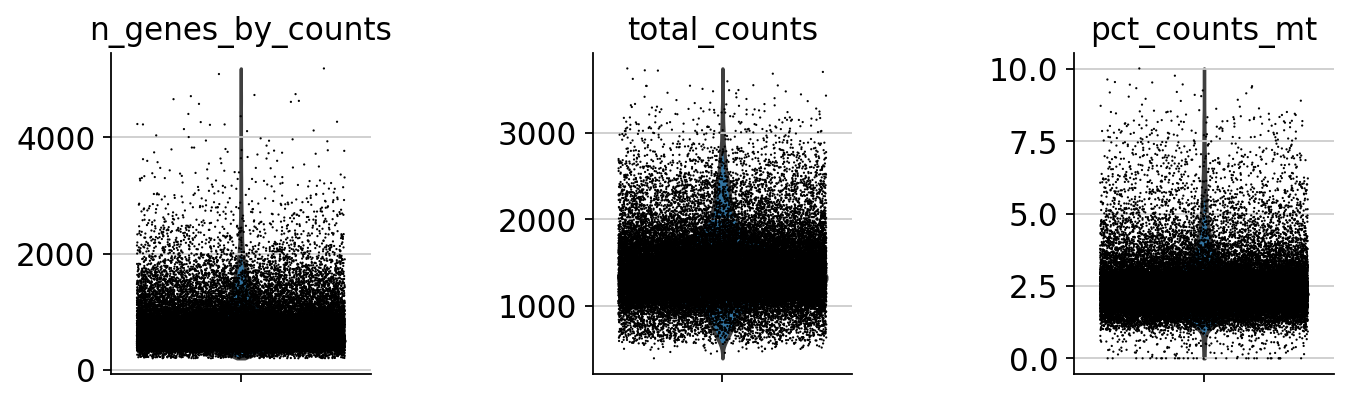

In [7]:
adata.var['mt'] = adata.var.index.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

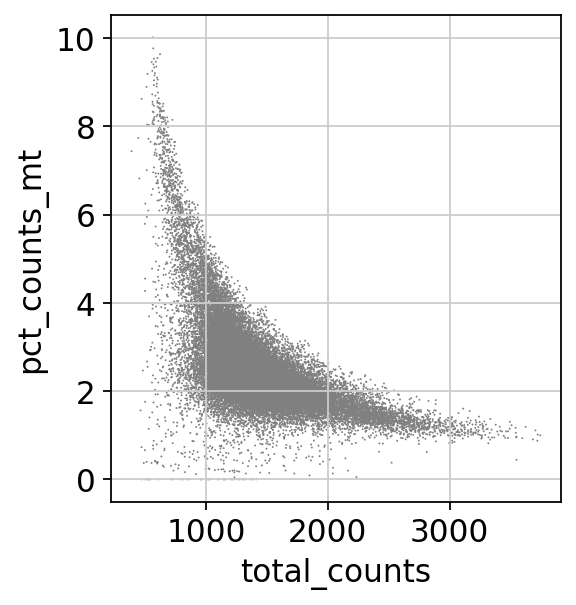

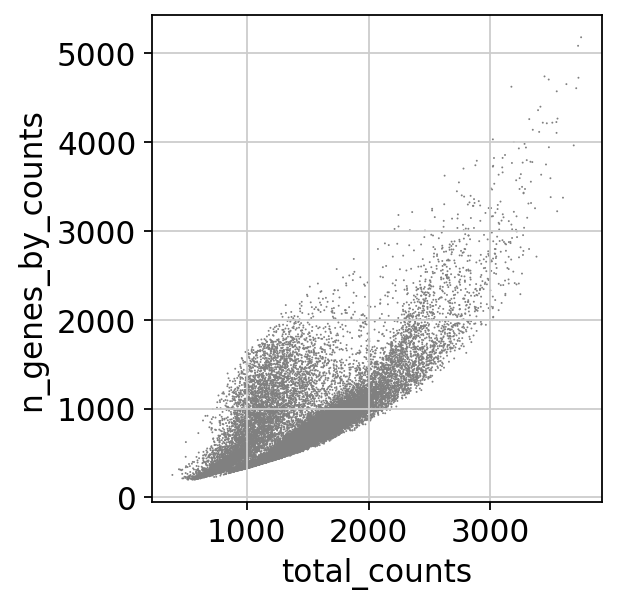

In [8]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [9]:
adata.raw = adata

In [10]:
sc.pp.filter_genes(adata, min_cells=3)

filtered out 11319 genes that are detected in less than 3 cells


In [11]:
sc.pp.normalize_total(adata, target_sum=1e3)

normalizing counts per cell
    finished (0:00:00)


In [12]:
sc.pp.log1p(adata)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


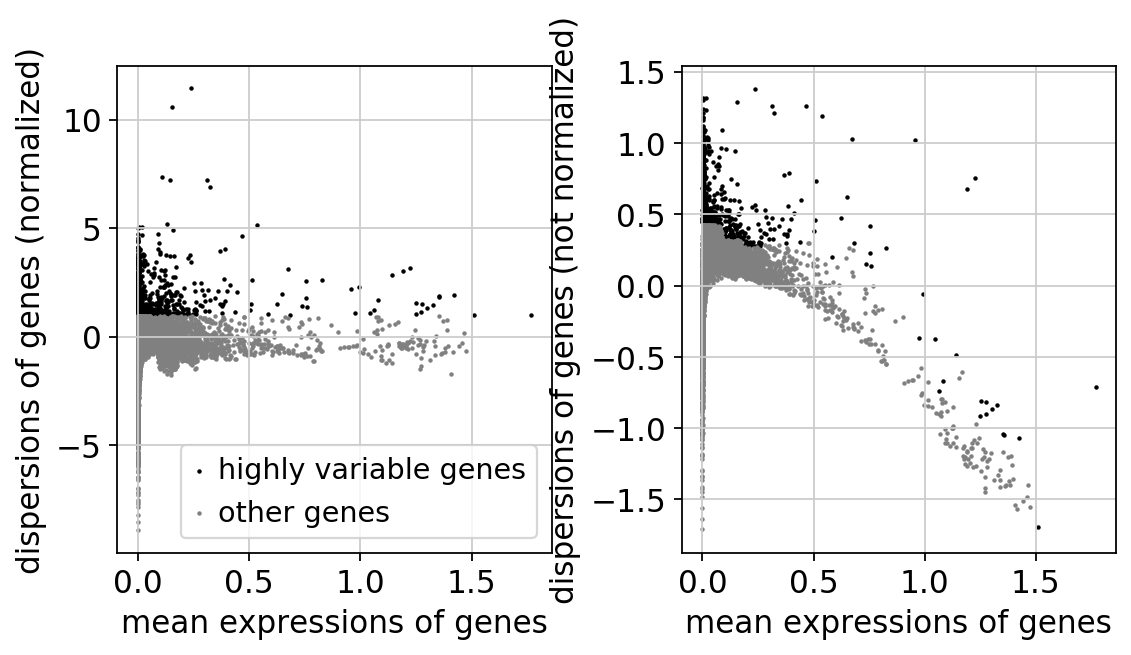

In [13]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

In [14]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 39563 × 2000
    obs: 'NAME', 'X', 'Y', 'Primary Lineages', 'kmeans', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Primary Lineages_colors', 'log1p'

In [16]:
sc.pp.regress_out(adata, ['batch'], n_jobs=1)

regressing out ['batch']
    finished (0:00:36)


In [17]:
sc.pp.scale(adata, max_value=10)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)


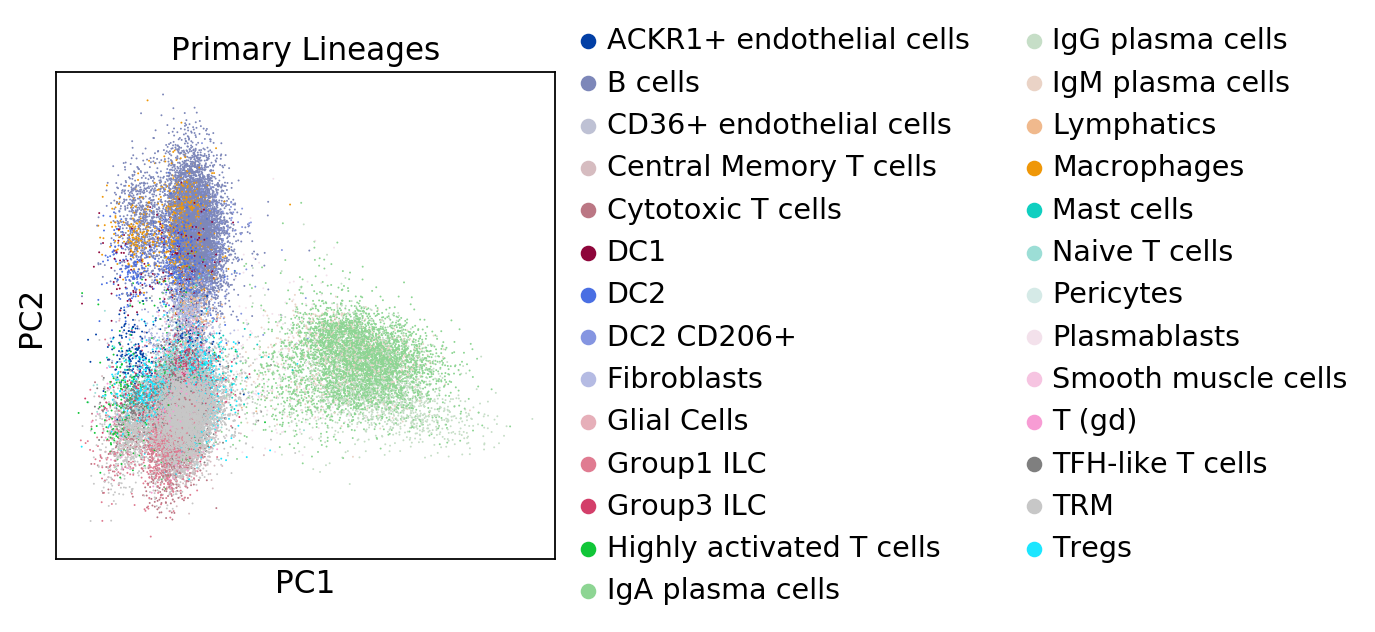

In [18]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color="Primary Lineages")

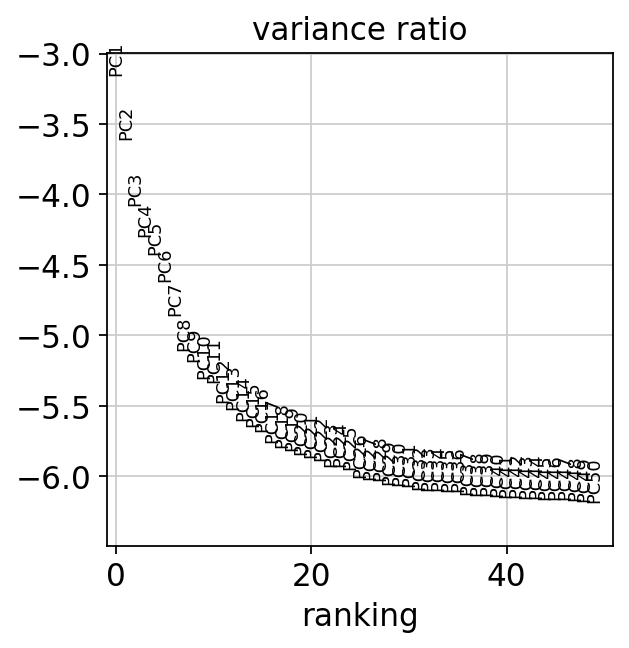

In [19]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

In [20]:
# sc.tl.rank_genes_groups(adata, 'Primary Lineages', method='wilcoxon')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, ncols=3)

In [21]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:33)


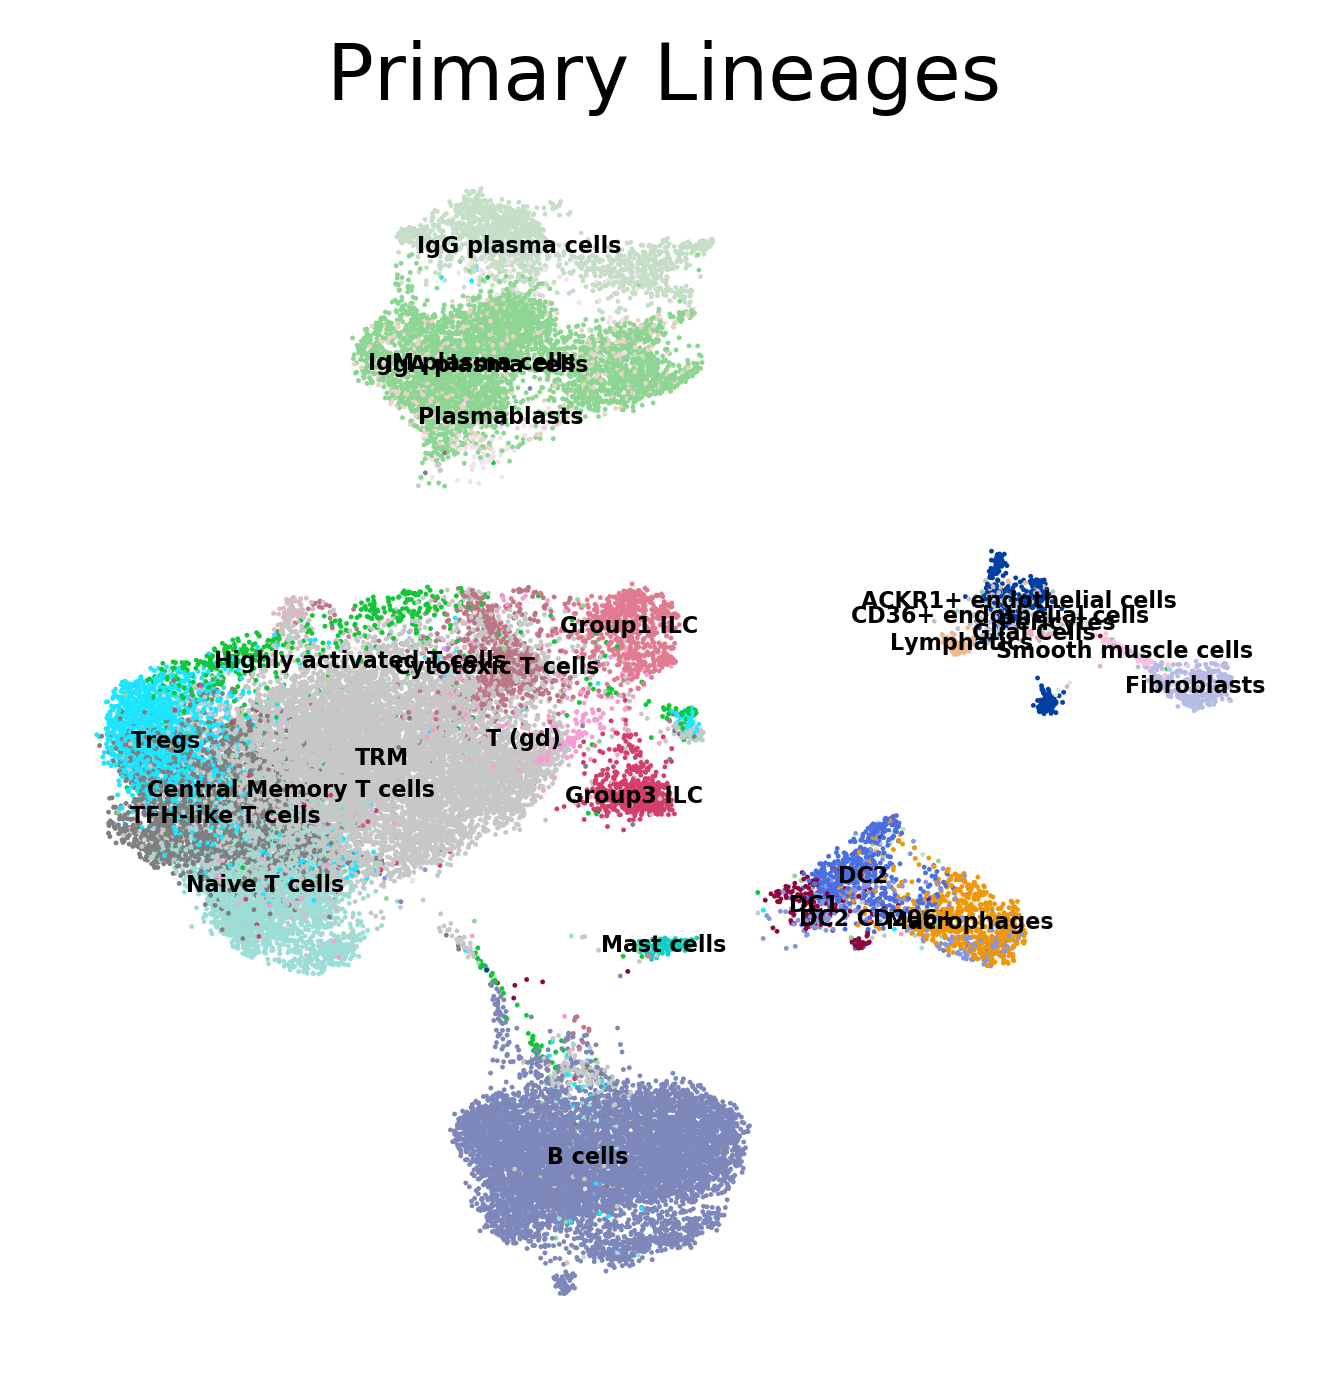

In [22]:
sc.settings.set_figure_params(dpi=200, facecolor='white')
sc.pl.umap(adata, color="Primary Lineages", legend_loc="on data", legend_fontsize=4, frameon=False)

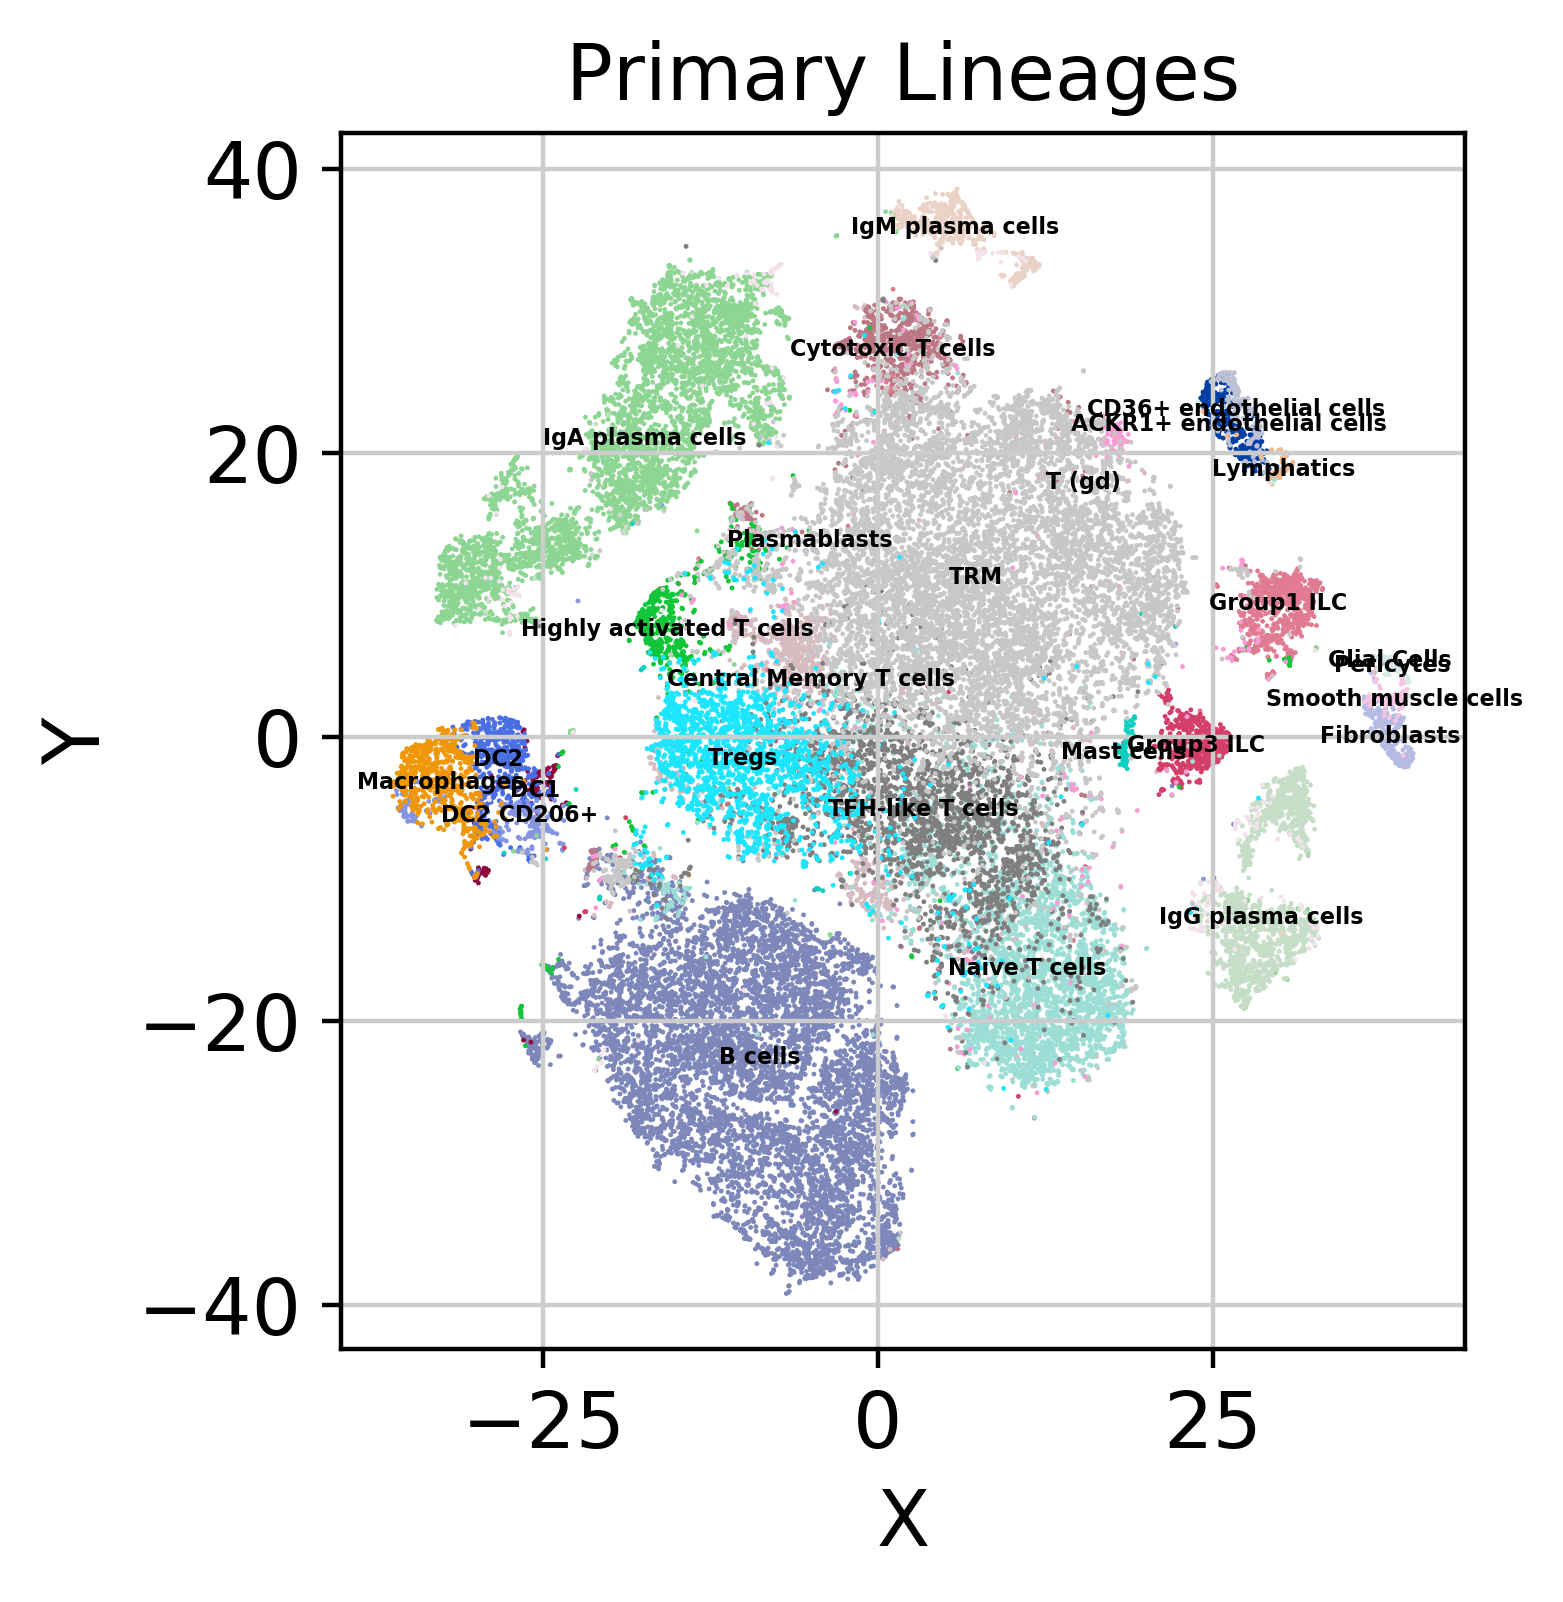

In [23]:
sc.settings.set_figure_params(dpi=200, facecolor='white')
sc.pl.scatter(adata, "X", "Y", "Primary Lineages", legend_loc="on data", legend_fontsize=4, frameon=False)

In [24]:
sc.tl.tsne(adata, n_pcs=50)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:01:56)


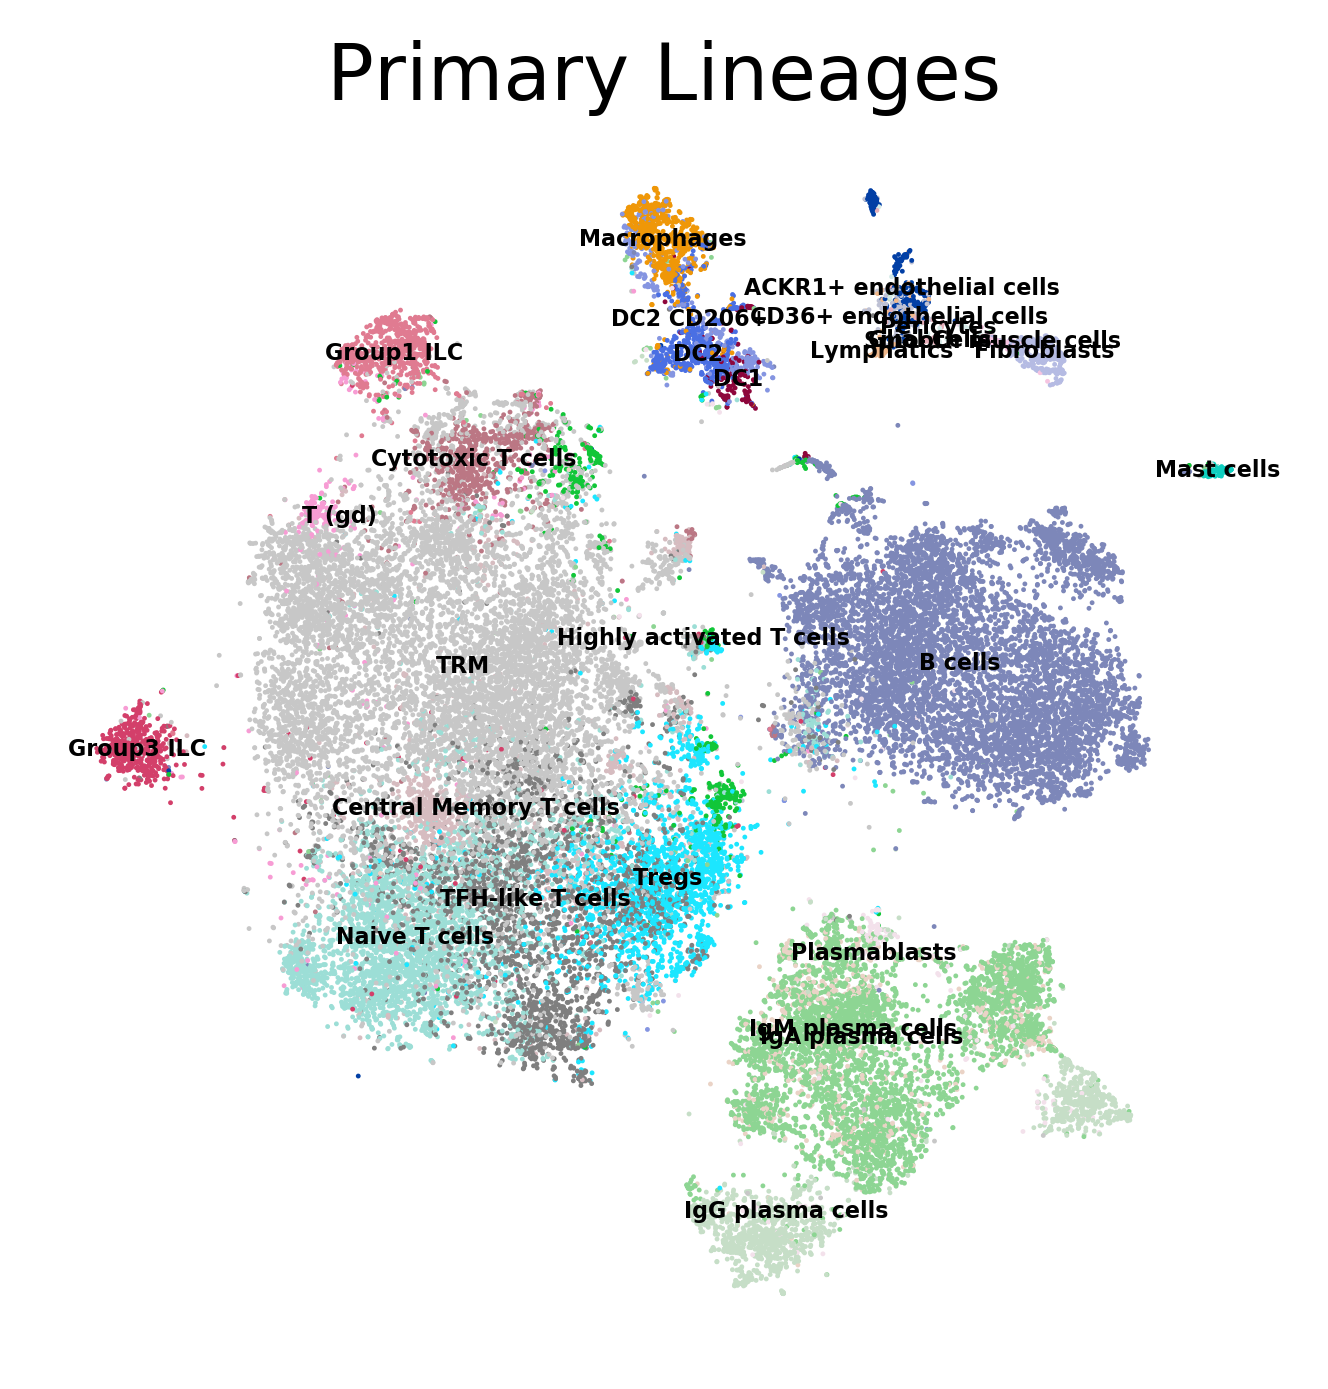

In [25]:
sc.settings.set_figure_params(dpi=200, facecolor='white')
sc.pl.tsne(adata, color="Primary Lineages", legend_loc="on data", legend_fontsize=4, frameon=False)

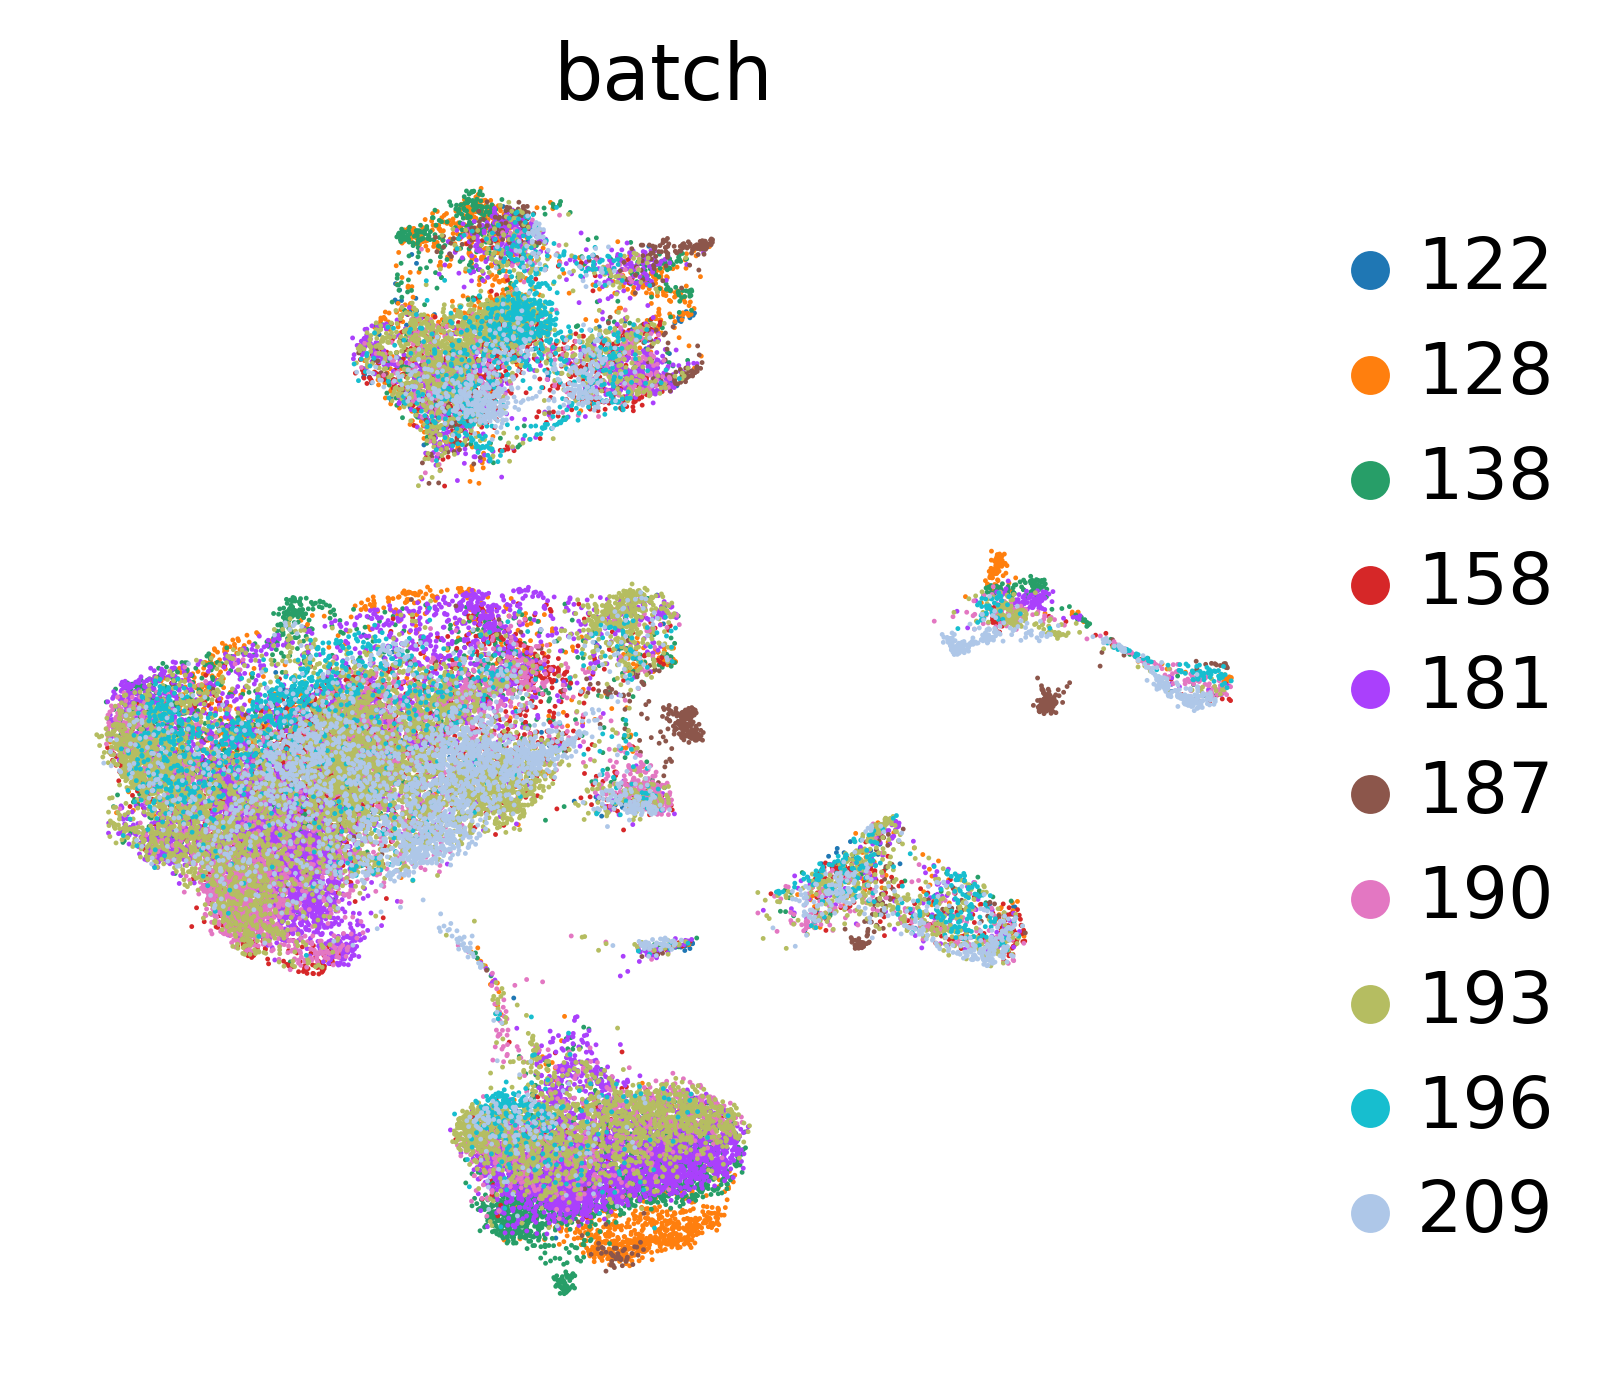

In [26]:
sc.pl.umap(adata, color="batch", frameon=False)

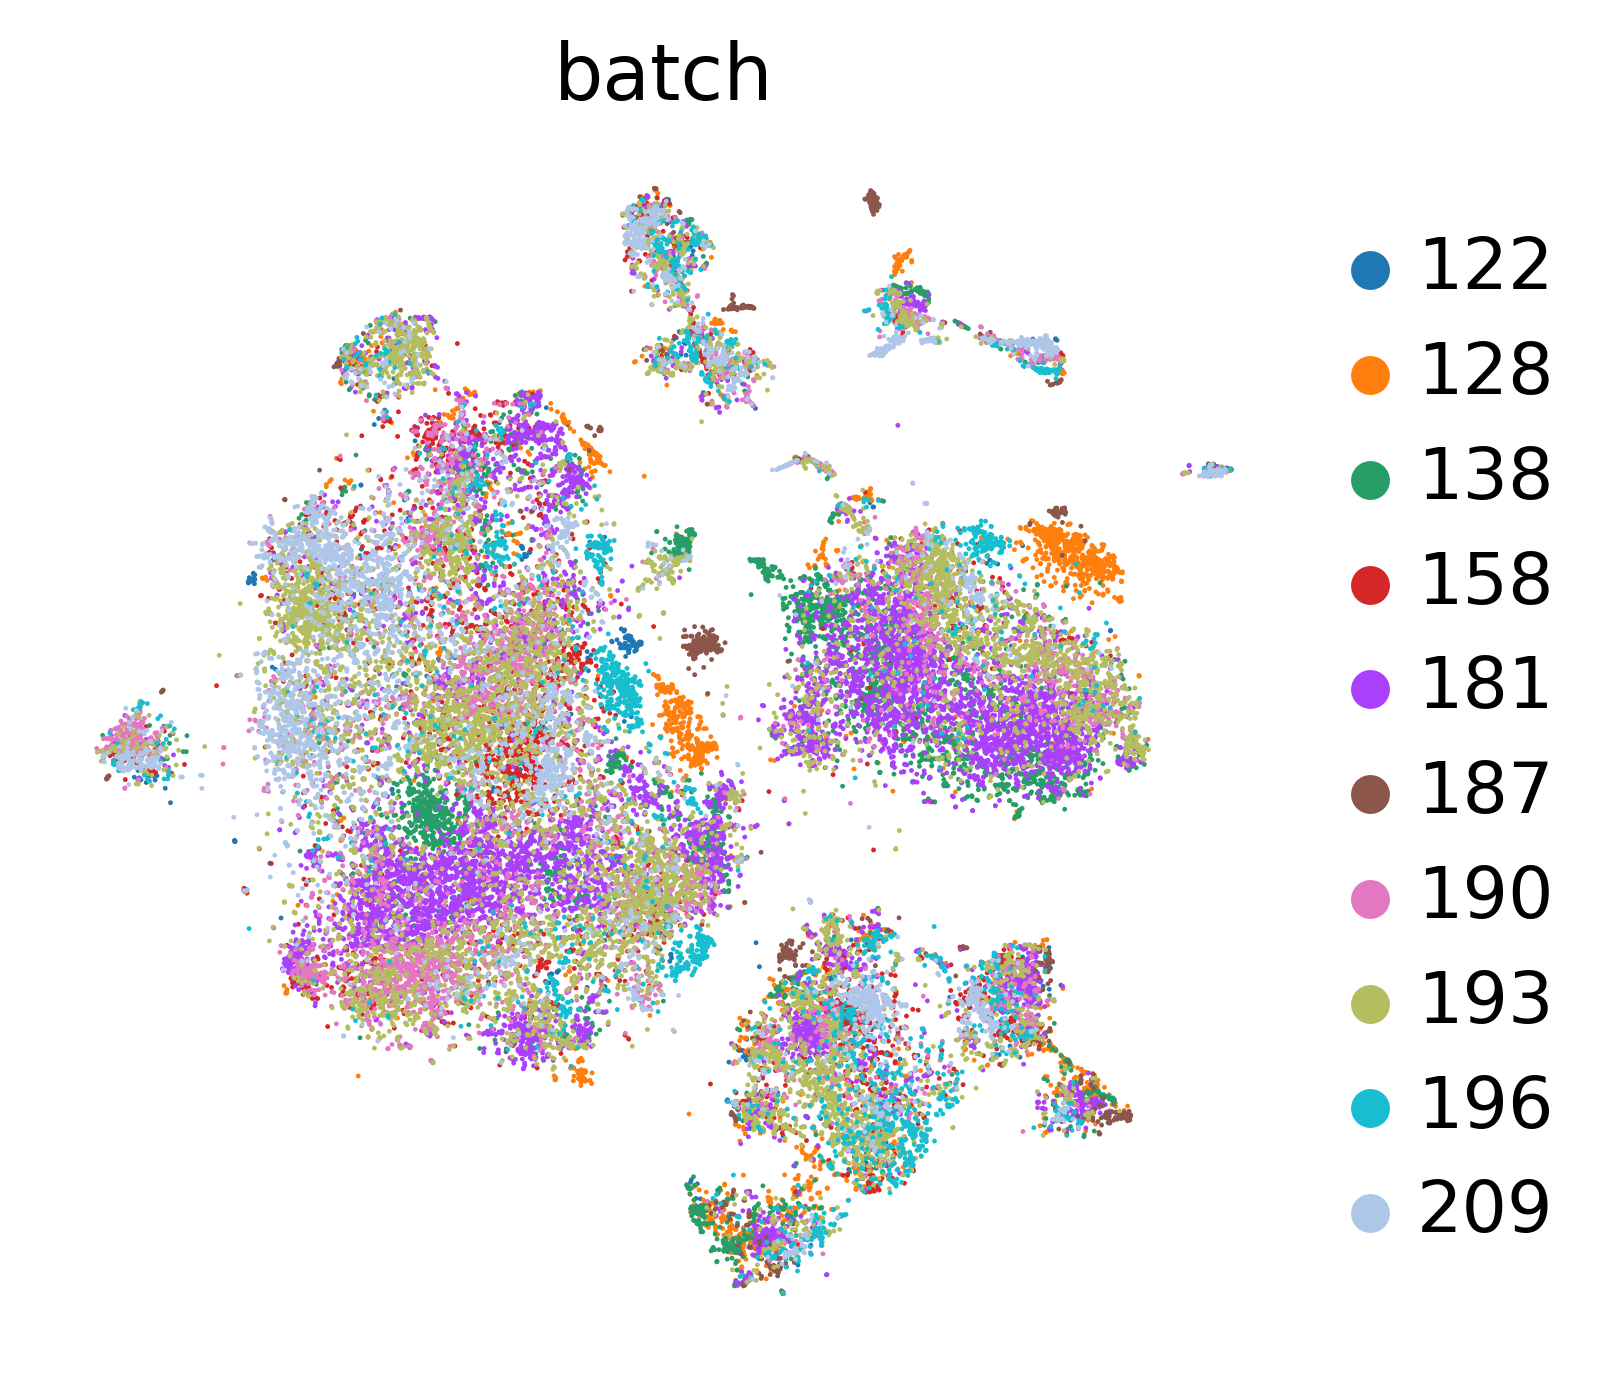

In [27]:
sc.pl.tsne(adata, color="batch", frameon=False)